# Generate weak labels - Prediction of A2C model


- Goal: Automatically generate weak labels to segment all four chambers in A4C view. 
- Method:
    - Taking advantage of the similarities between A2C and A4C views, it’s reasonable to assume that most of the features used for segmenting A2C are useful for segmenting A4C views as well. Thus, we propose to use the weights learned during the A2C segmentation to generate weak labels for the A4C view segmentation. 
    - As atrium and ventricles share similar structures, except for the geographical location in the image, we hypothesize that the A2C model would be able to recognize atrium and ventricles in any part of the image given the spatial invariance properties of CNNs. As such, labels to train the network were generated by predicting the A2C trained model weights on a A4C view images, where we expected the output of the network to be a mask containing four segments, that is two atriums and two ventricles.

In [1]:
import numpy as np
from glob import glob
import cv2
import os
import matplotlib.pyplot as plt

from utils import util_seg

2024-08-13 23:47:58.290012: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-08-13 23:47:58.290092: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-08-13 23:47:58.290098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Vizualize u-net pred - donuts

In [2]:
color_list_a4c = [(0,0,0), (255,135,125), (255,65,65), (103,254,255), (0,128,255)]
label_map_a4c = [ "background","left_atrium", "left_ventricle", "right_atrium", "right_ventricle","heart"]

def step_visualization(indir):
    """
    Visualizes the step-by-step prediction process for a given set of images.
    Args:
        indir (str): The base directory path where the images are located.
    Returns:
        None
    """

    step1 = os.path.join(indir, 'a4c_step1_labels')
    step1_stretched = os.path.join(indir, 'a4c_step1_labels_stretched_rv')
    step3 = os.path.join(indir, 'a4c_final_inference')

    for filename in glob(os.path.join(indir, 'a4c_images/*.npy')):

        ID = os.path.basename(filename)
        img_fov = np.load(filename)

        img_256 = cv2.resize(img_fov, (256,256), interpolation = cv2.INTER_AREA)
        img_256 = ((img_256-img_256.min())/(img_256.max() - img_256.min())).astype('float32')

        #### Step 1 prediction ####
        step1_label = np.load(os.path.join(step1, ID))
        step1_img_rgb = util_seg.cat_to_color(step1_label[np.newaxis], color_list_a4c)    

        #### Step 2 prediction ####
        step1_stretched_label = np.load(os.path.join(step1_stretched, ID))
        step1_stretched_img_rgb = util_seg.cat_to_color(step1_stretched_label[np.newaxis], color_list_a4c)

        #### Step 3 prediction ####
        step3_label = np.load(os.path.join(step3, ID))
        step3_img_rgb = util_seg.cat_to_color(step3_label[np.newaxis], color_list_a4c)   

        fig, ax_arr = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(30, 20))
        ax1, ax2, ax3, ax4 = ax_arr.ravel()

        ax1.imshow(img_256[...,0], cmap='gray')
        ax1.set_title(f'Original img', fontsize=20)
        ax1.set_ylabel(ID, fontsize=20)

        ax1.axes.get_xaxis().set_ticks([])
        ax1.axes.get_yaxis().set_ticks([])

        ax2.imshow(step1_img_rgb[0].astype('uint8'), cmap="gray")
        ax2.set_title(f'Step 1 - Initial weak label',fontsize=20)

        ax3.imshow(step1_stretched_img_rgb[0].astype('uint8'), cmap="gray")
        ax3.set_title(f'Step 2 - Prediction',fontsize=20)

        ax4.imshow(step3_img_rgb[0].astype('uint8'),cmap='gray')
        ax4.set_title(f'Step 3 - Prediction',fontsize=20)

        plt.show()

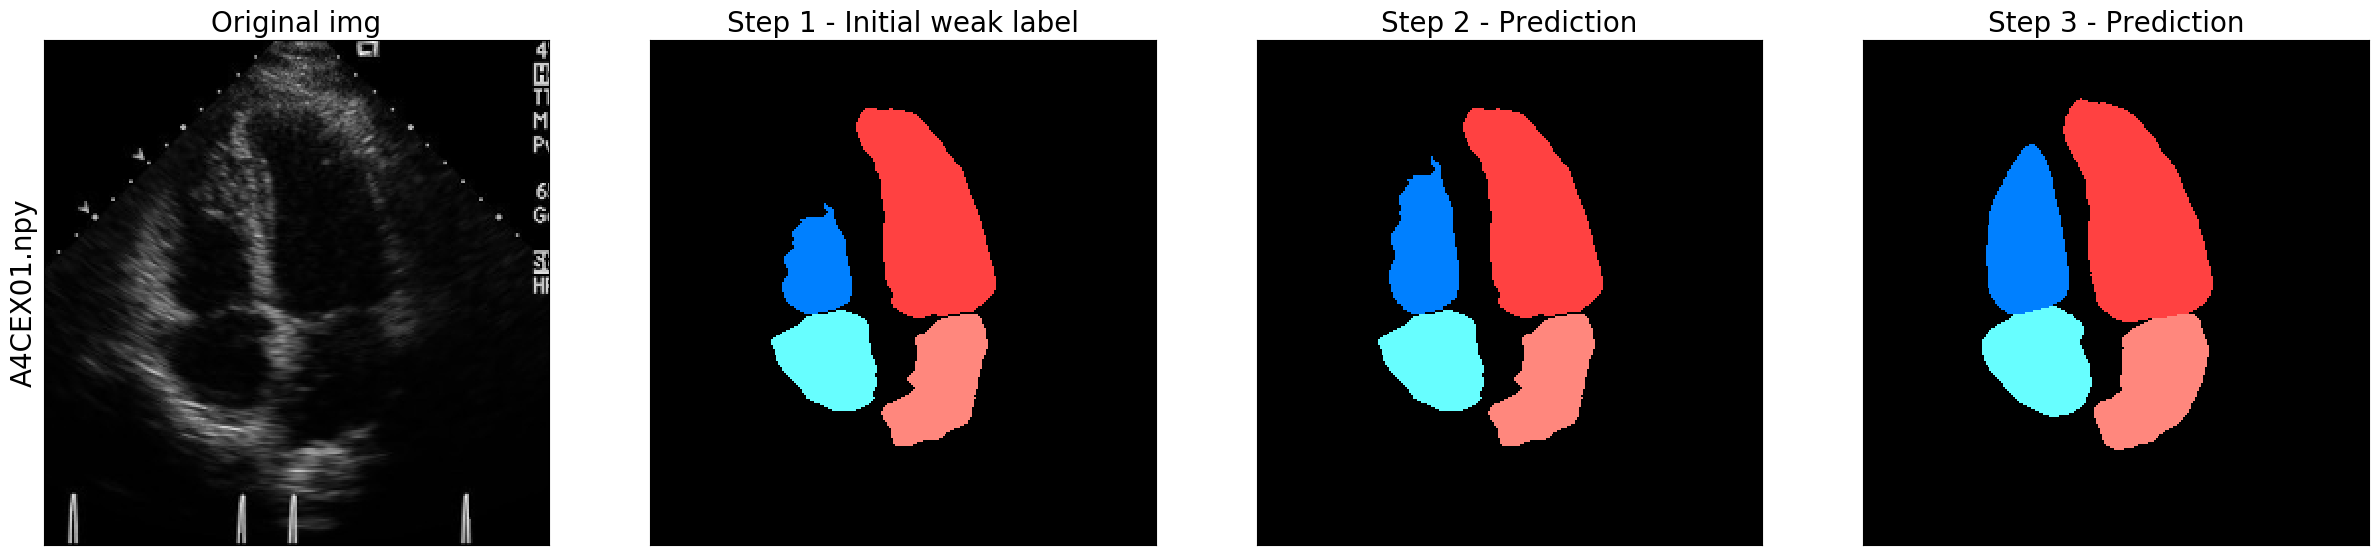

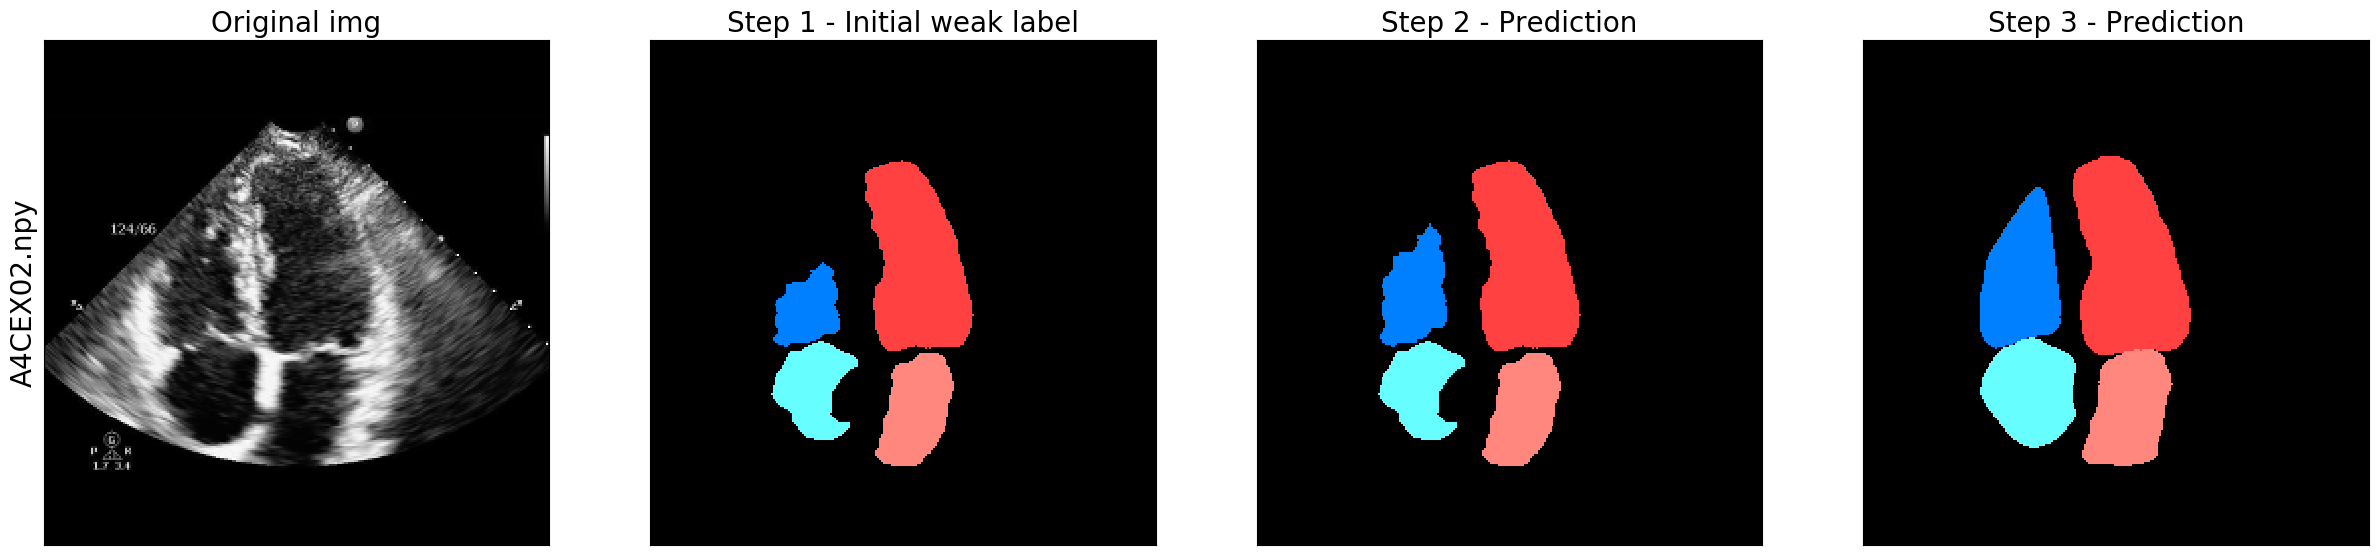

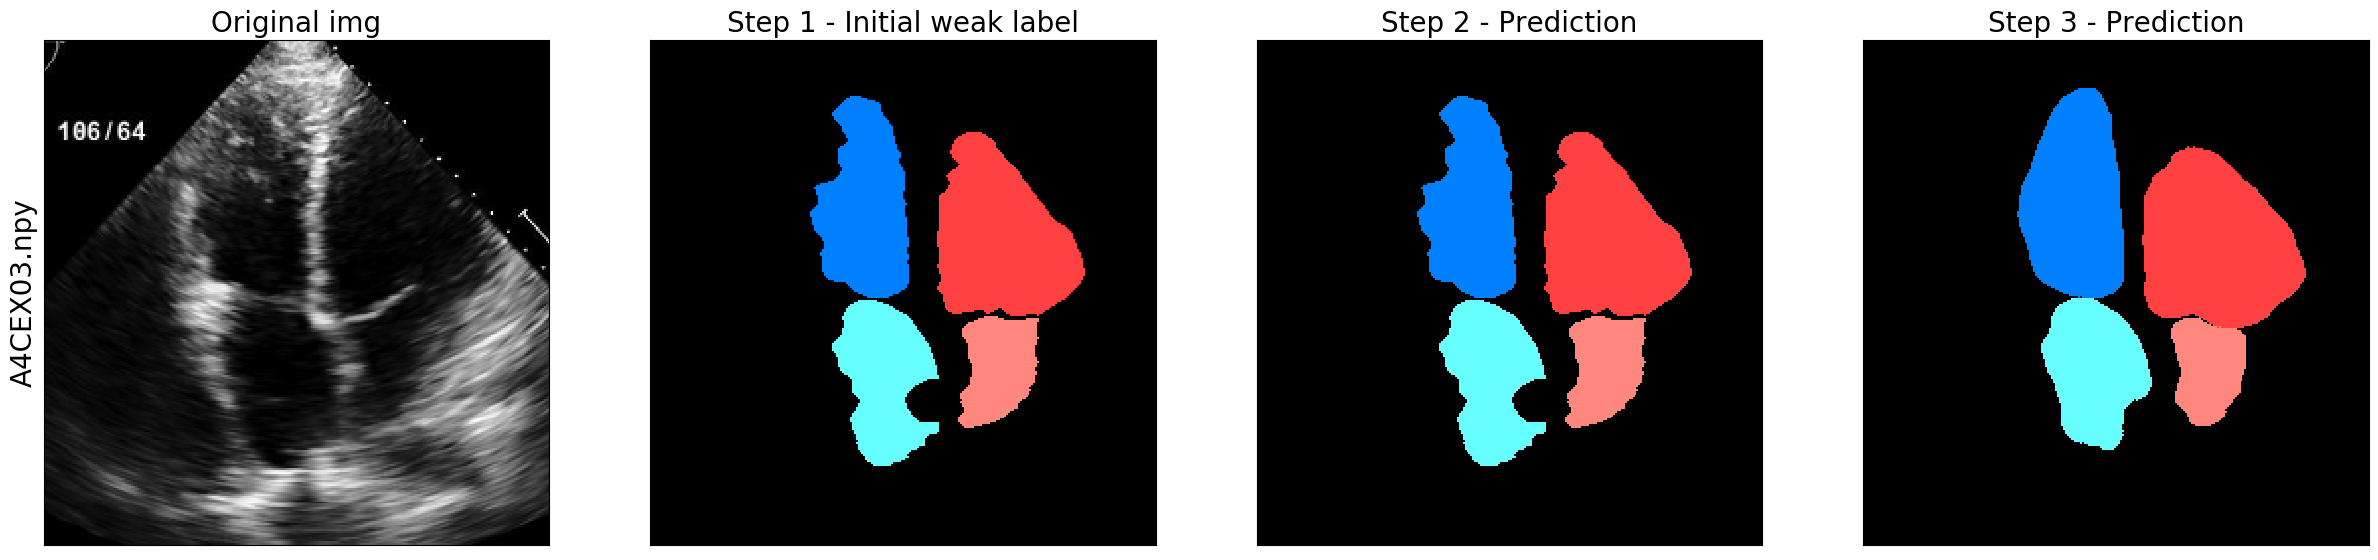

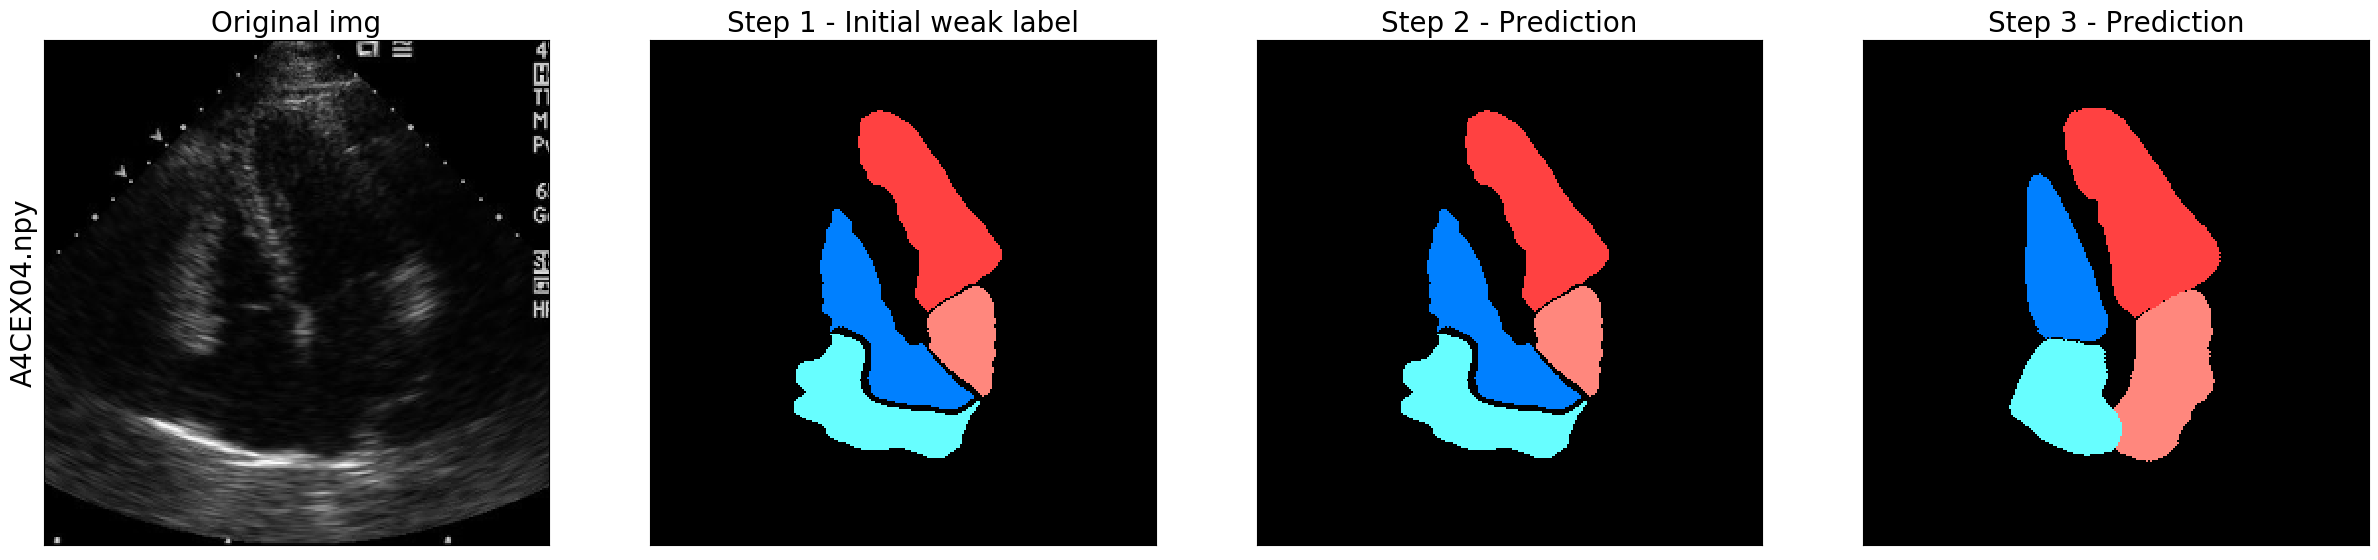

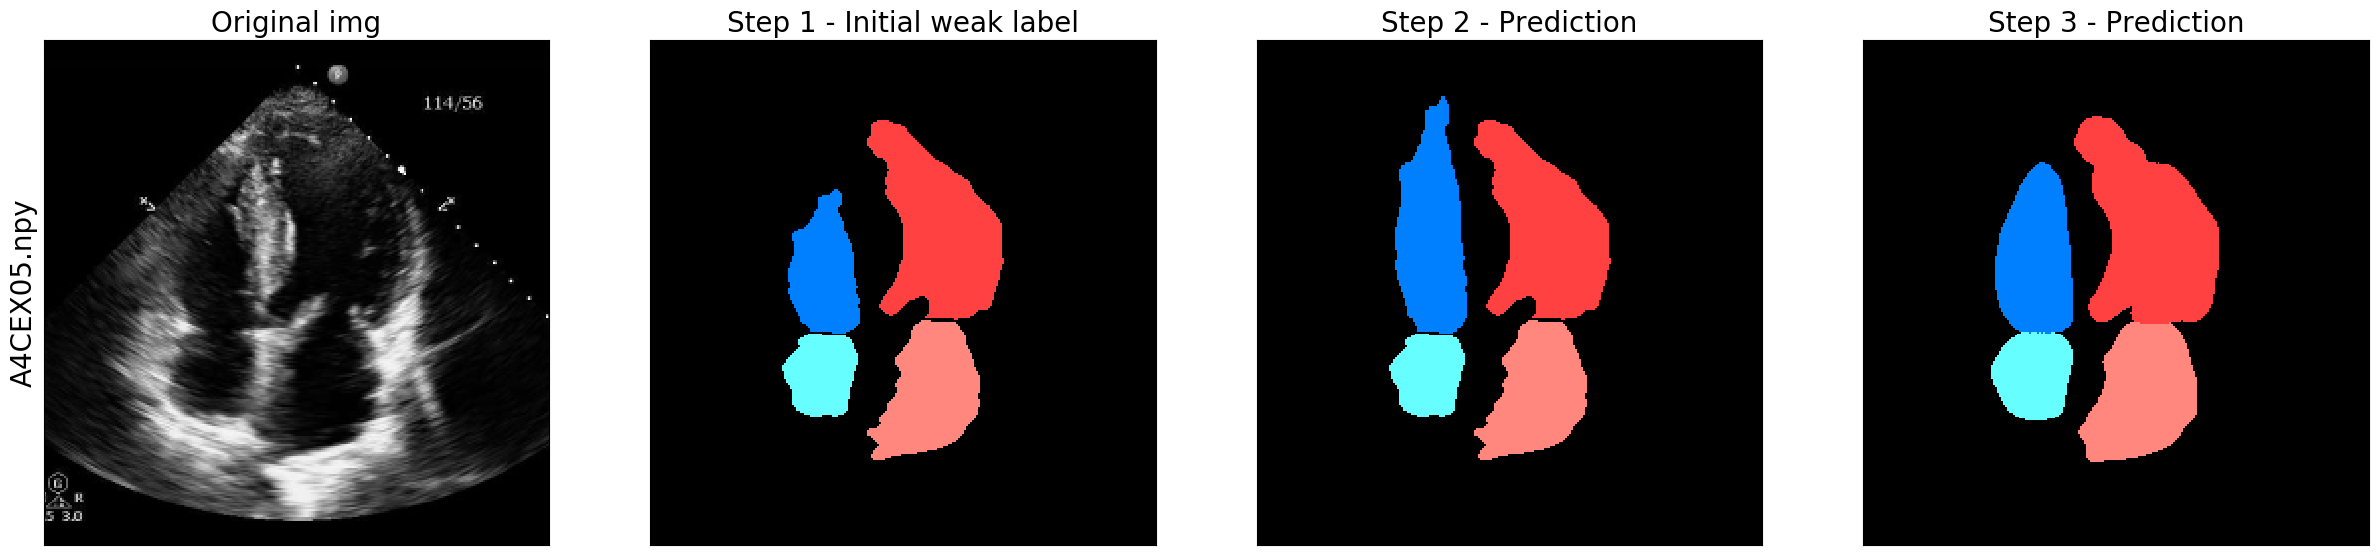

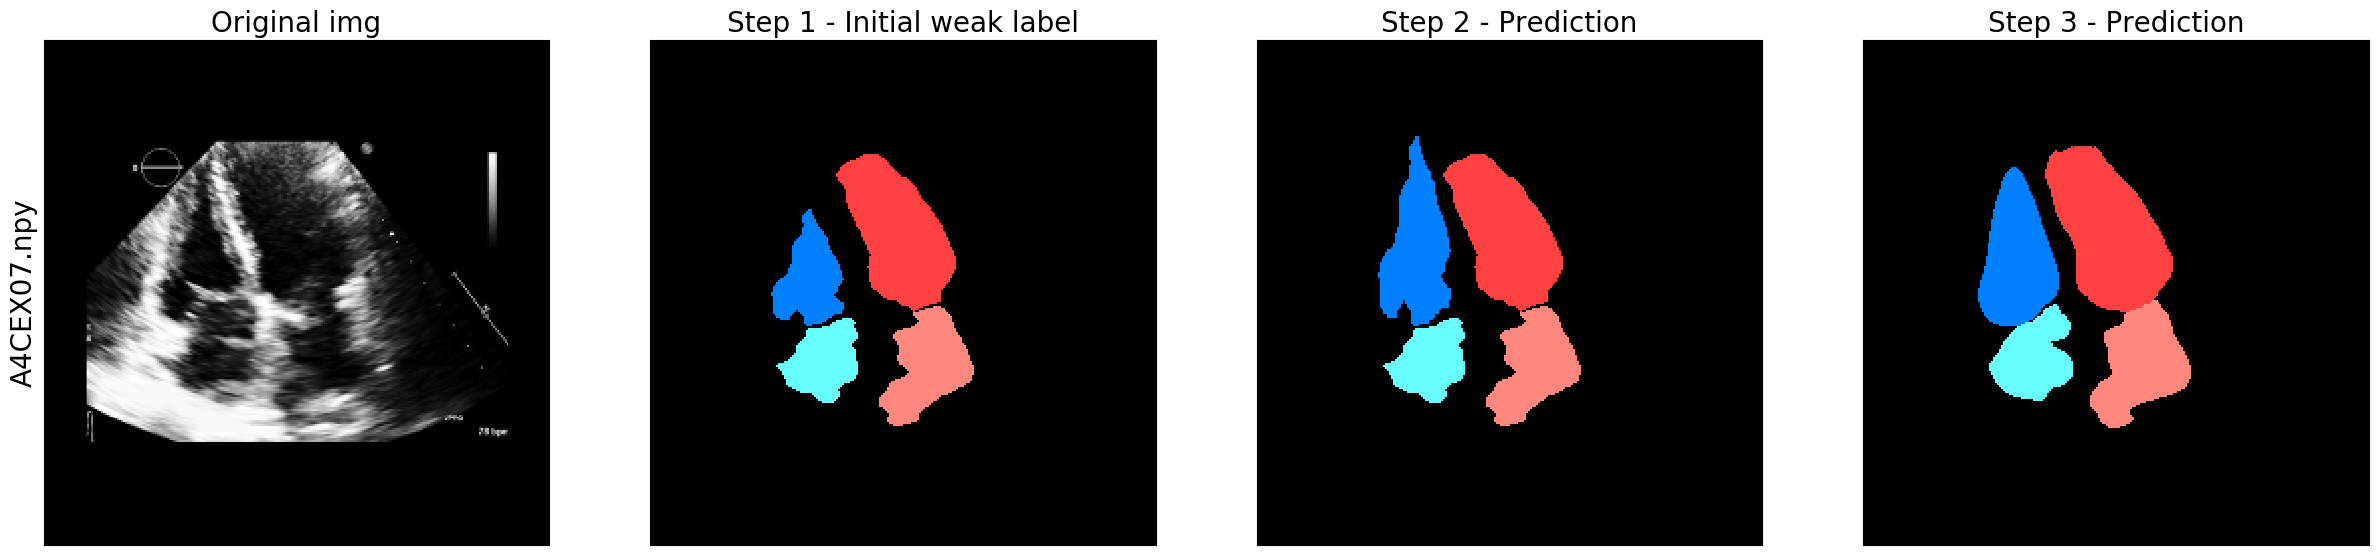

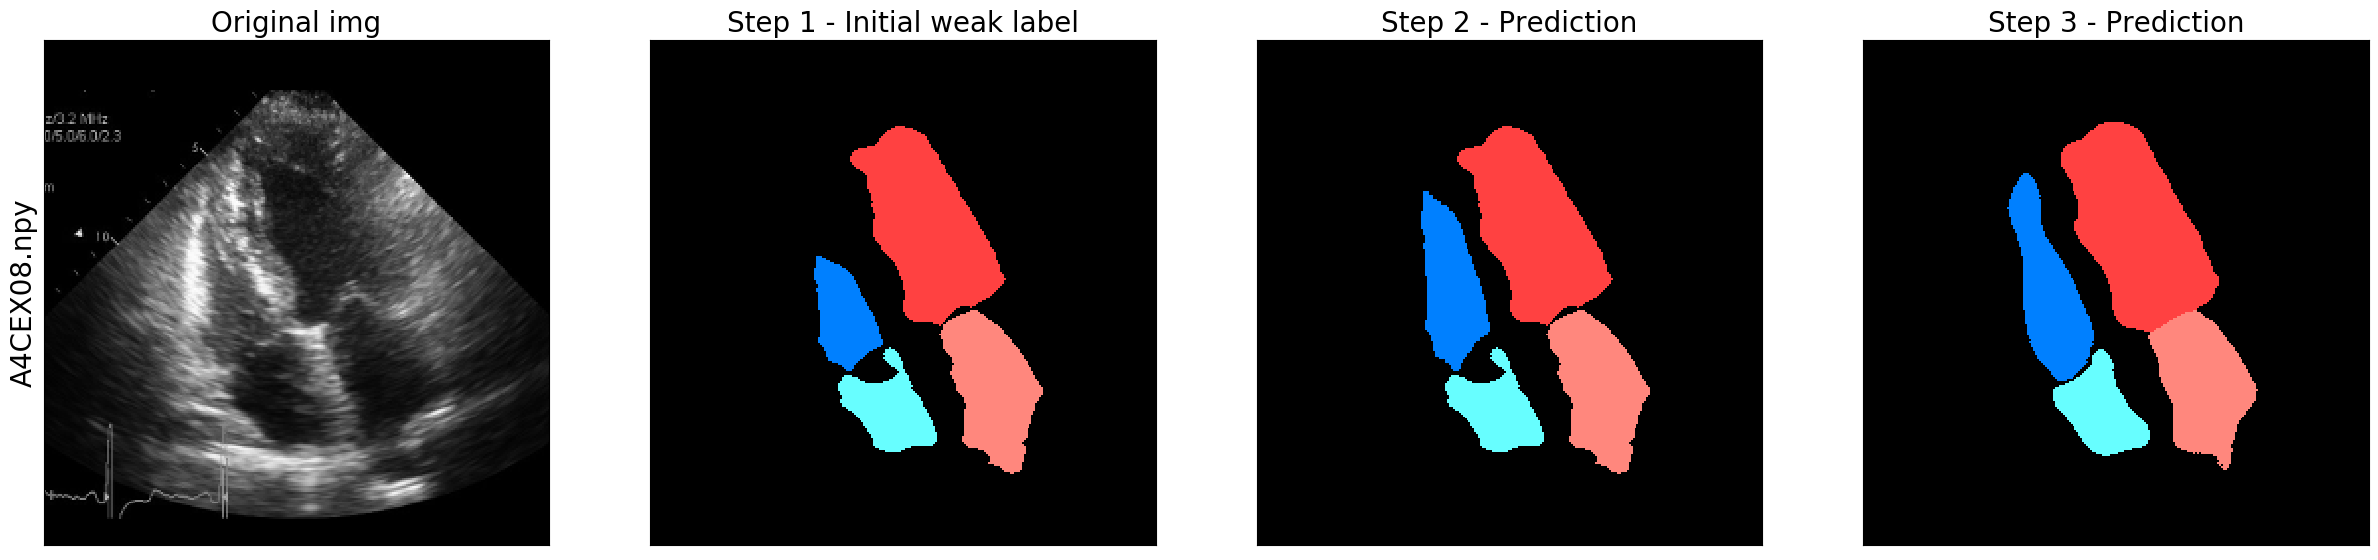

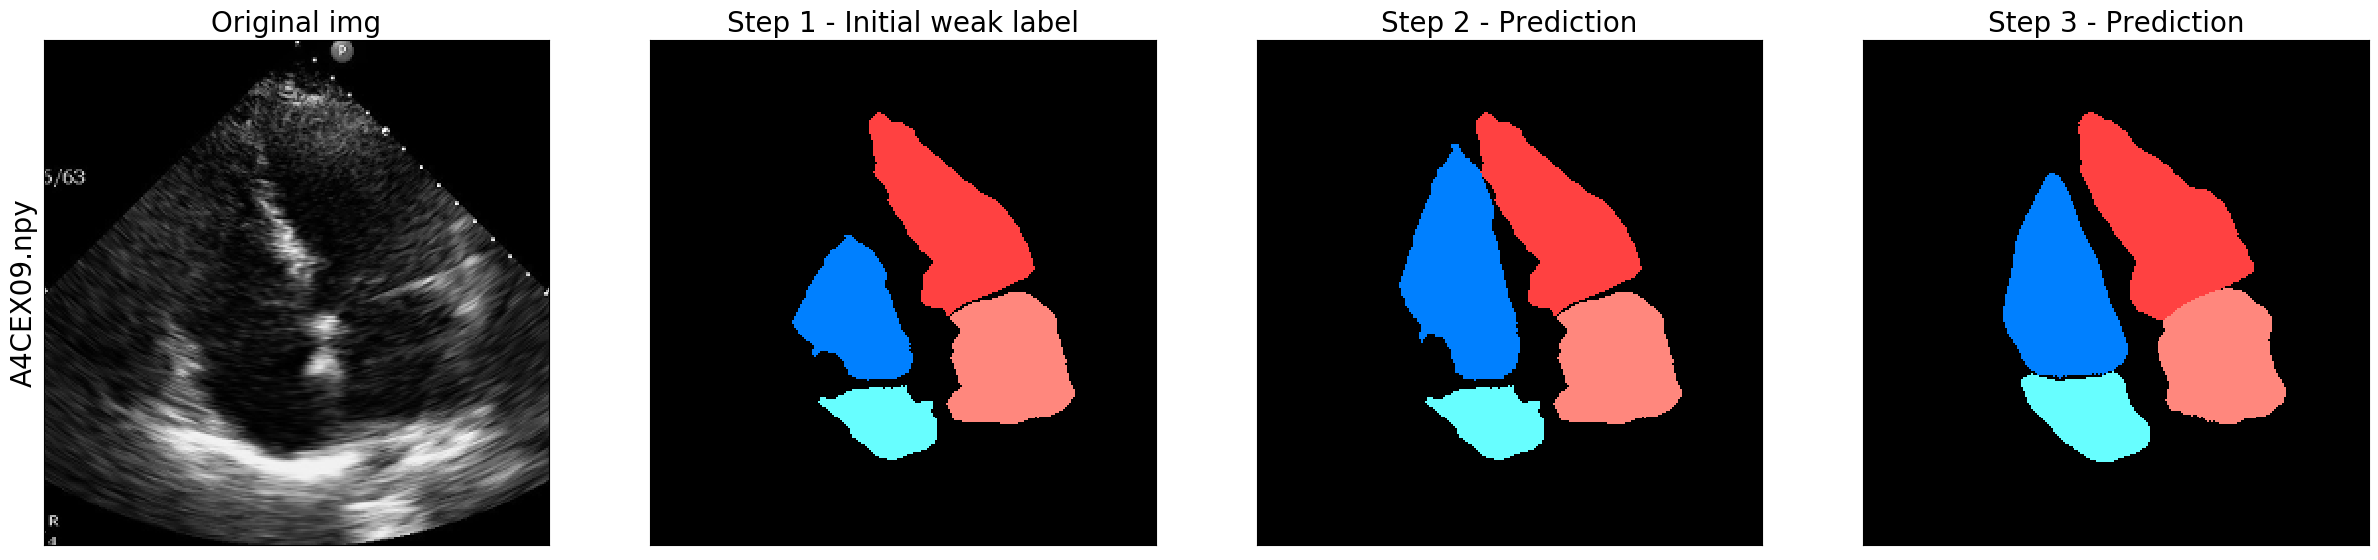

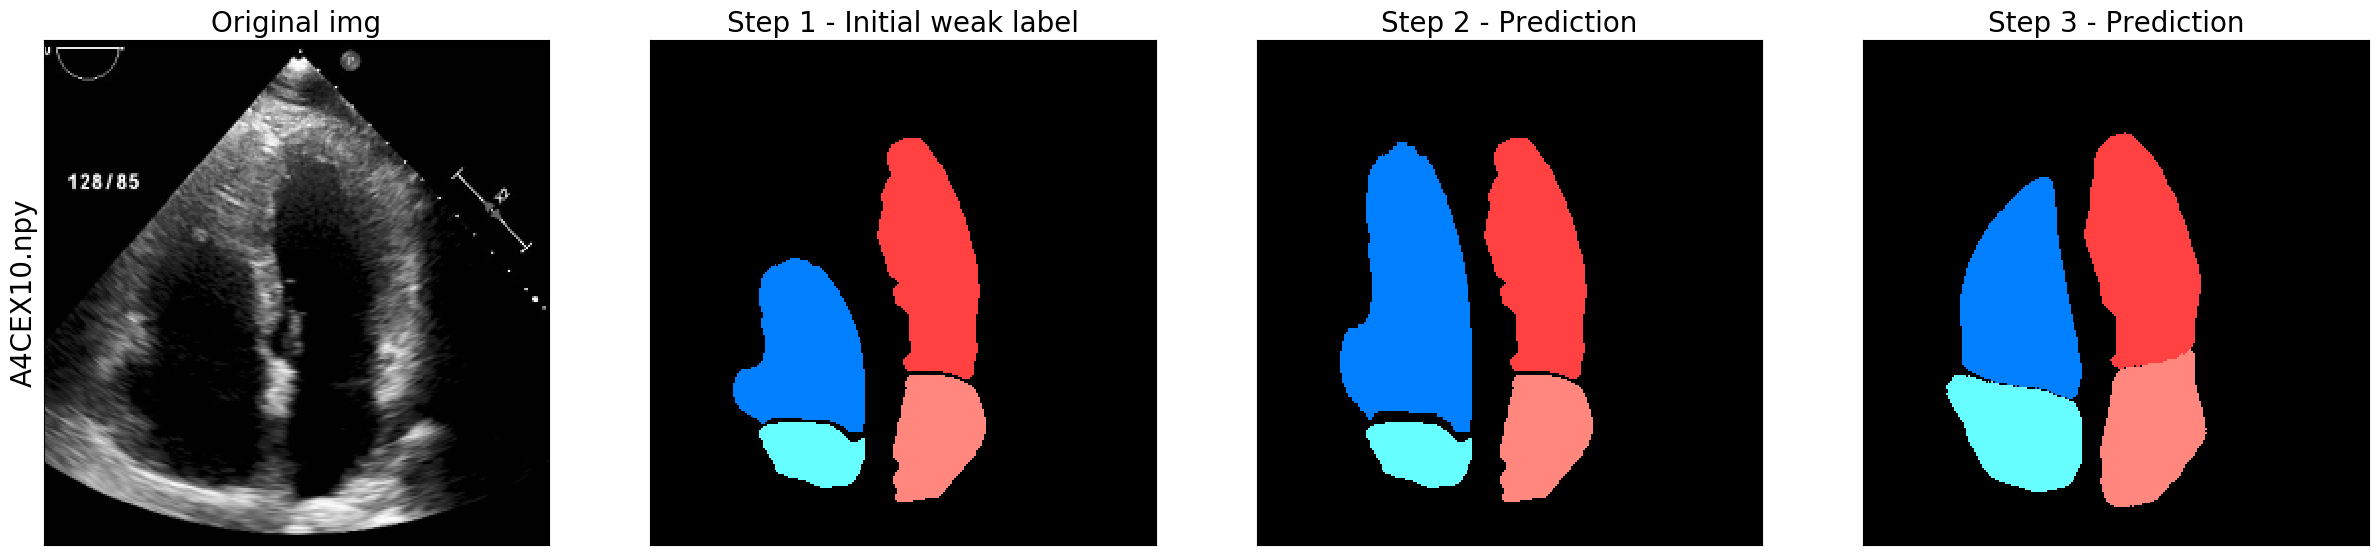

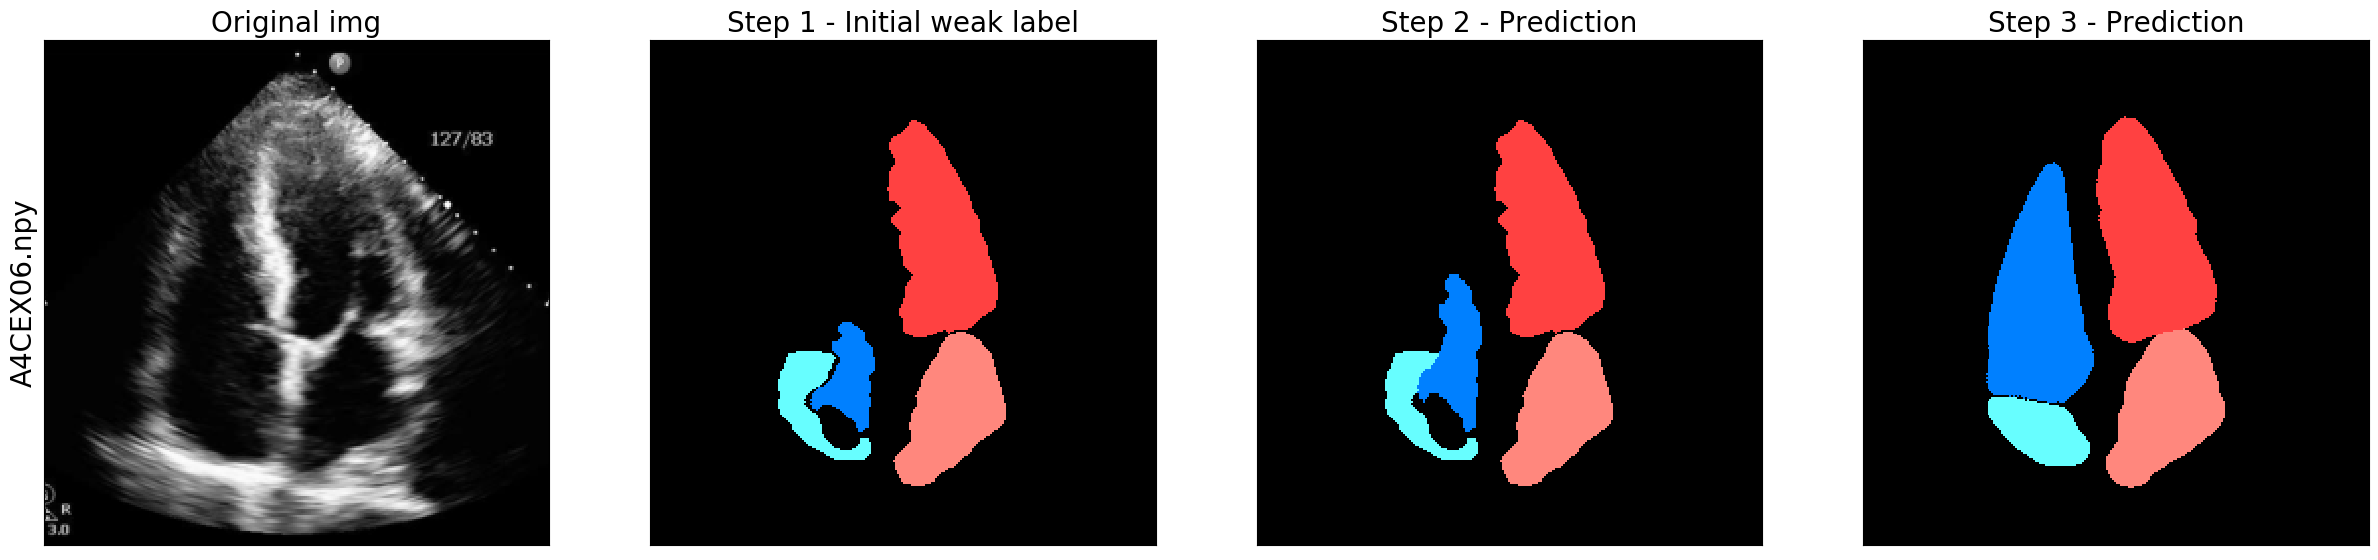

In [3]:
indir = "example_data/A4C"
step_visualization(indir)